<a href="https://colab.research.google.com/github/Leothorn/EVA8/blob/main/EVA8__Assignment_2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import torch
import torchvision # provide access to datasets, models, transforms, utils, etc
import random
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import copy
torch.set_printoptions(linewidth=120)


In [15]:
train_set = torchvision.datasets.MNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

test_set = torchvision.datasets.MNIST(
    root='./data'
    ,train=False
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

modified_train_set = copy.deepcopy(train_set)
modified_test_set  = copy.deepcopy(test_set)

# Create the modified train set which adds a random number to the training and testing dataset
modified_train_set = [(record[0], record[1], (x := random.randint(0, 9)), record[1] + x) for record in modified_train_set]
modified_test_set = [(record[0], record[1], (x := random.randint(0, 9)), record[1] + x) for record in modified_test_set]




In [16]:
sample = iter(modified_train_set) #Initialize iterator on the modified trainset

5 6 11


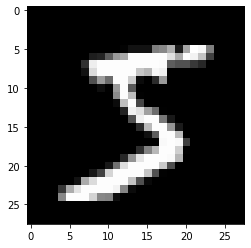

In [17]:
(img,label,random_int,total)=next(sample)
plt.imshow(img.squeeze(), cmap='gray')
print(label,random_int,total)

In [18]:
batchsize = 32  # This modified batch has a batch size of 32

train_loader = torch.utils.data.DataLoader(modified_train_set, batch_size=batchsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(modified_test_set, batch_size=batchsize)

In [19]:
sample = iter(train_loader)
(img,label,random_int,total)=next(sample)

labels: tensor([9, 8, 8, 7, 1, 2, 3, 2, 0, 1, 4, 4, 3, 3, 0, 6, 3, 1, 1, 2, 6, 3, 0, 5, 3, 4, 3, 0, 0, 0, 0, 8])
random_int tensor([4, 6, 0, 3, 6, 5, 3, 9, 8, 4, 1, 6, 0, 7, 8, 6, 8, 0, 6, 7, 5, 4, 3, 1, 8, 3, 1, 8, 6, 7, 2, 2])
total tensor([13, 14,  8, 10,  7,  7,  6, 11,  8,  5,  5, 10,  3, 10,  8, 12, 11,  1,  7,  9, 11,  7,  3,  6, 11,  7,  4,  8,
         6,  7,  2, 10])


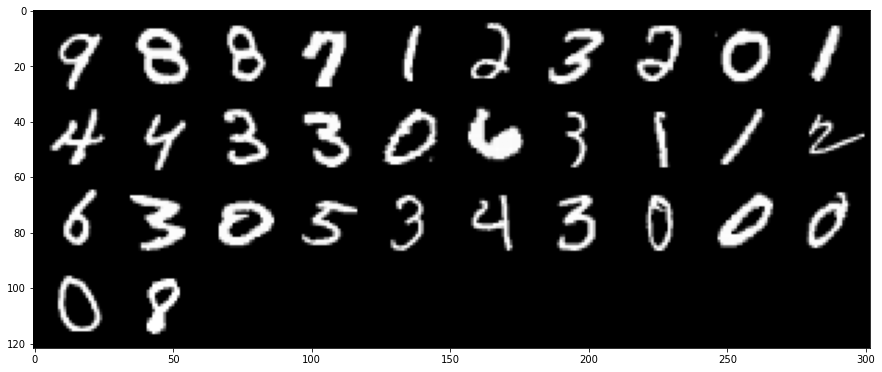

In [20]:
grid = torchvision.utils.make_grid(img, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print('labels:', label)
print('random_int',random_int)
print('total',total)

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Define model layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 10)
        self.fc1 = nn.Linear(32 * 7 * 7, 10)
        self.fc2 = nn.Linear(10, 32)  # change the output size of fc2 to 32
        self.fc3 = nn.Linear(32, 18)  # add a fully-connected layer with 18 output neurons

    def forward(self,x,y):
        # Define the forward pass of the model
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = x.view(-1, 32 * 7 * 7)
        x = self.fc1(x)
        return x
        # One-hot encode y and concatenate to x
        y_one_hot = F.one_hot(y, num_classes=10).torch.cuda.FloatTensor
        x = torch.cat((x, y_one_hot), dim=1)
        # Pass x through the fully-connected layer fc2 and fc3        
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)
        return x


# Initialize the model and define the loss function and optimizer
model = Model()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to GPU
model = model.to(device)

# Define the number of epochs to train for
num_epochs = 10
# Train the model
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    # Loop over the train_loader
    for i, (inputs, labels, random_ints, totals) in enumerate(train_loader):

        inputs = inputs.cuda()
        labels = labels.cuda()
        random_ints = random_ints.cuda()
        totals = totals.cuda()
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(inputs,random_ints)
        # Compute the loss
        loss = loss_fn(output,labels)
        # Backward pass
        loss.backward()
        # Update the parameters
        optimizer.step()
    # Set the model to evaluation mode
    model.eval()
    # Initialize some metric variables
    total_loss = 0
    num_correct = 0
    num_samples = 0
    # Loop over the test_loader
    with torch.no_grad():
        for i, (inputs, labels, random_ints, totals) in enumerate(test_loader):

            inputs = inputs.cuda()
            labels = labels.cuda()
            random_ints = random_ints.cuda()
            totals = totals.cuda()
            # Forward pass
            output = model(inputs,random_ints)
            # Compute the loss
            loss = loss_fn(output, labels)
            total_loss += loss.item()
            # Compute the accuracy
            _, preds = output.max(dim=1)
            num_correct += (preds == labels).sum().item()
            num_samples += inputs.size(0)

    # Print the epoch loss and accuracy
    print(f'Epoch {epoch+1}: Loss = {total_loss/len(test_loader):.4f}, Accuracy = {num_correct/num_samples:.4f}')


Epoch 1: Loss = 0.2463, Accuracy = 0.9226
Epoch 2: Loss = 0.1402, Accuracy = 0.9618
Epoch 3: Loss = 0.0998, Accuracy = 0.9699
Epoch 4: Loss = 0.0837, Accuracy = 0.9741
Epoch 5: Loss = 0.0680, Accuracy = 0.9776
Epoch 6: Loss = 0.0607, Accuracy = 0.9795
Epoch 7: Loss = 0.0614, Accuracy = 0.9794
Epoch 8: Loss = 0.0502, Accuracy = 0.9827
Epoch 9: Loss = 0.0619, Accuracy = 0.9792
Epoch 10: Loss = 0.0474, Accuracy = 0.9848
